In [1]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering
from graph_deep_decoder.model import select_model, Model

SEED = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### BL signal

<ipython-input-2-fab082ce2246>:56: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.abs(Lambda))


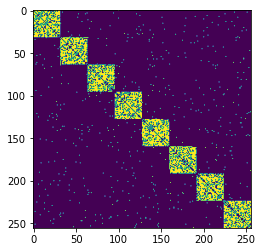

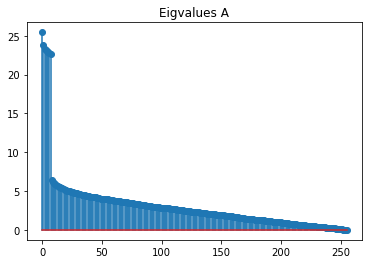

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['k'] = 8
G_params['type_z'] = ds.CONT
G_params['N'] = 256
G_params['p'] = 0.75
G_params['q'] = 0.0075

# Signal parameters
K = 3
params = 8
n_signals = 100
n_p = .1

# Model parameters
epochs = 500
lr = .001

# Create graph
G = ds.create_graph(G_params, SEED)
A = np.asarray(G.W.todense())
S = A

plt.figure()
plt.imshow(A)
Lambda, V = utils.ordered_eig(A)

# Create filter H
hs = np.random.rand(K)
hs /= np.sum(np.abs(hs))
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
H_norm = H/np.linalg.norm(H)

# Original models
Exps = [
        {'type': 'TV', 'A': A, 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'L': G.L, 'alpha': 0.1, 'legend': 'LR'},
        {'type': 'BL', 'S': S,  'alpha': 0.1, 'max_coefs': False, 'legend': 'BL'},
        {'type': 'BL',  'S': S, 'alpha': params, 'max_coefs': False, 'legend': 'BL'},
        {'type': '2LD', 'fts': 150, 'std': 1, 'H_norm': True, 'legend': '2L-GCG'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*6, 'fts': [97]*5 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .001, 'H_norm': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': hs, 'H_norm': False}, 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [8, 16, 32, 64] + [G.N]*2, 'fts': [97]*5 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'legend': 'GD'},
        ]

L_H, V_H = utils.ordered_eig(H)
plt.figure()
plt.stem(np.abs(Lambda))
plt.title('Eigvalues A')

for exp in Exps:
    if exp['type'] == '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] == 'DD' and exp['ups'] == Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] == 'DD' and exp['ups'] == Ups.U_MAT:
        H = utils.create_filter(S, exp['h_params'])
        exp['Us'] =[H]*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

In [3]:
err1 = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = ds.bandlimited_signal(Lambda, V, params)
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        model = select_model(exp, x_n, epochs, lr, device)

        if type(model) == Model:
            weights[j] = model.count_params()
            _, err1[j, i, :], _ = model.fit(x_n, x, device=device)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err1[j, i, :] = np.repeat(err_non_train, epochs)

    print(i, end=' ')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 --- 6.395577347278595 minutes ---


TV (0.0): 0.0267
LR (0.0): 0.0433
BL (0.0): 0.0103
BL (0.0): 0.0033
2L-GCG (38400.0): 0.0043
GCG (37733.0): 0.0037
GD (37733.0): 0.0154


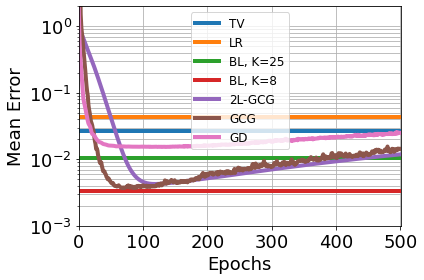

In [4]:
# %matplotlib qt
leg = []
for i, exp in enumerate(Exps):
    txt = exp['legend']
    if exp['type'] == 'BL':
        if exp['alpha'] >= 1:
            alpha = exp['alpha']
        else:
            alpha = int(exp['alpha']*G.N)
        txt += ', K=' + str(alpha)
    leg.append(txt)

# Plots Mean Error
mean_mse = np.mean(err1, axis=1)
fig = plt.figure()
plt.semilogy(mean_mse.T, linewidth=4)
plt.legend(leg, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Mean Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-3, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

for i, err_model in enumerate(mean_mse.min(axis=1)):
    print('{} ({}): {:.4f}'.format(Exps[i]['legend'], weights[i], err_model))

### DW-MEDIAN signals

In [5]:
err2 = np.zeros((len(Exps), n_signals, epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.MEDIAN, K)
    x_dw.to_unit_norm()
    x = x_dw.x
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        model = select_model(exp, x_n, epochs, lr, device)
        if type(model) == Model:
            weights[j] = model.count_params()
            _, err2[j, i, :], _ = model.fit(x_n, x, device=device)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err2[j, i, :] = np.repeat(err_non_train, epochs)
    
    print(i, end = ' ')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 --- 5.957103232542674 minutes ---


TV (0.0): 0.030
LR (0.0): 0.037
BL (0.0): 0.023
BL (0.0): 0.017
2L-GCG (38400.0): 0.017
GCG (37733.0): 0.017
GD (37733.0): 0.006


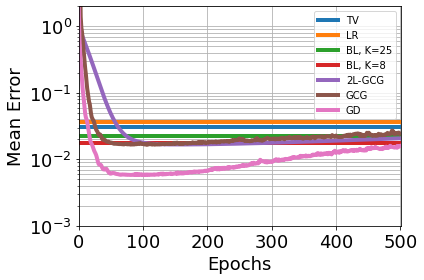

In [6]:
leg = []
for i, exp in enumerate(Exps):
    txt = exp['legend']
    if exp['type'] == 'BL':
        if exp['alpha'] >= 1:
            alpha = exp['alpha']
        else:
            alpha = int(exp['alpha']*G.N)
        txt += ', K=' + str(alpha)
    leg.append(txt)
    
# Plots Mean Error
mean_mse = np.mean(err2, axis=1)
fig = plt.figure()
plt.semilogy(mean_mse.T, linewidth=4)
plt.legend(leg, prop={'size': 10})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Mean Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-3, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

for i, err_model in enumerate(mean_mse.min(axis=1)):
    print('{} ({}): {:.3f}'.format(Exps[i]['legend'], weights[i], err_model))

In [7]:
plt.show()